## Batching, visualizing and comparing transformer embeddings

In this demo we will showing you how to batch your data for inputting into NLP transformers. We will also visualize some embeddings of sentences to see if similar sentences are placed in different areas. We will also be computing the similarity between different sentences using the cosine similarity measure.

In [ ]:
# Install extra dependencies
!pip install -q transformers==4.27.0
!pip install -q wandb==0.10.8
!pip install -q torchmetrics==0.11.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 9.6 MB/s eta 0:00:00


Here we are just showing how to create a classification model. Note the use of AutoTokenizer and AutoModel. This makes it easier to find the correct model and tokenizer when you the particular model of interest which in this case is "distilbert-base-uncased". Note you should always make sure you are using the tokenizer that is associated with the same model.
Notice the token 102 is used to separate the two sentences.

In [ ]:
from transformers import DistilBertConfig, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
inputs = tokenizer("Hello, my dog is cute", "Here is another sentence.", return_tensors="pt")
print(inputs)
outputs = model(**inputs)
print(outputs)
print(outputs['logits'].shape)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,  2182,  2003,
          2178,  6251,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0392, -0.1922]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
torch.Size([1, 2])


Instead of using the sequence classification model we can instead use the token classification model. Take a look at the shape of the output. Can you see why it is that shape?
The model outputs one token for each input token and we have 8 input tokens.


In [ ]:
from transformers import AutoModelForTokenClassification
import torch

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased")
tokens = tokenizer.tokenize("Hello, my dog is cute")
print(tokens)
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
print(inputs)

outputs = model(**inputs)
print(outputs['logits'].shape)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

['hello', ',', 'my', 'dog', 'is', 'cute']
{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 8, 2])


### Creating a batch of tokenized sentences.

In this cell we create a batch of tokenized sentences. Notice the first tokenizer line fails since all the sentences are of different lengths. The second tokenizer line works since it ensures each sentence has a max length of 8 and pads sentences with zero if they are shorter than 8 and truncates sentences that are longer than 8 tokens in length.

In [ ]:
from transformers import AutoModelForTokenClassification
import torch

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased")
inputs1 = ["Hello, my dog is cute", "Your cat is very beautiful", "I love all animals", "animals are so fun to play with", "my fish are dying"]
inputs1 = tokenizer(inputs1, return_tensors="pt")
#inputs1 = tokenizer(inputs1, padding=True, truncation=True, max_length=8, return_tensors="pt")
print(inputs1)
outputs = model(**inputs1)
print(outputs['logits'].shape)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

ValueError: ignored

Here we write some visualization code that take two tensors. Each tensor should be a batch of sentences that have been embedded by a model. The code will then reduce the dimensionality of tensors to 2D and then visualize each batch using a different colour in a scatter plot.

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_two_batches(tensor1, tensor2):

  combined_batch = np.concatenate([tensor1, tensor2], axis=0)

  # perform t-SNE to reduce tensors to 2 dimensions
  tsne = TSNE(n_components=2, perplexity = 5, n_iter=5000)
  combined_2d = tsne.fit_transform(combined_batch)

  tensor1_2d = combined_2d[:len(tensor1), :]
  tensor2_2d = combined_2d[len(tensor2):, :]

  # extract x and y coordinates from tensors
  x1 = tensor1_2d[:, 0]
  y1 = tensor1_2d[:, 1]
  x2 = tensor2_2d[:, 0]
  y2 = tensor2_2d[:, 1]

  # create two scatter plots with different colors
  plt.scatter(x1, y1, c='r', label='batch 1')
  plt.scatter(x2, y2, c='b', label='batch 2')
  plt.legend()
  plt.show()

In this cell we visualize two batches of sentences which have been embedded using the AutoModelForTokenClassification model. Note we need to remove the randomly initalized classification head in order to get to the actual output embeddings for each token. The final embedding per sentence is done by taking the average pool of the tokens other than the CLS token which is the first token. So we do not include the CLS token in the average.

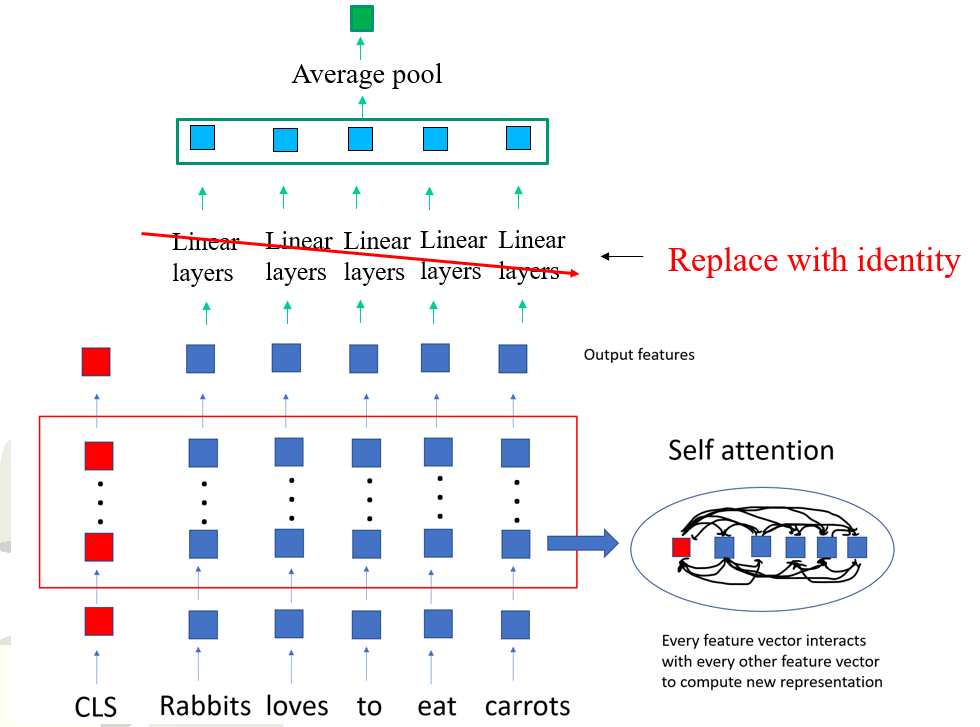

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

torch.Size([5, 9, 768])
torch.Size([5, 12, 768])


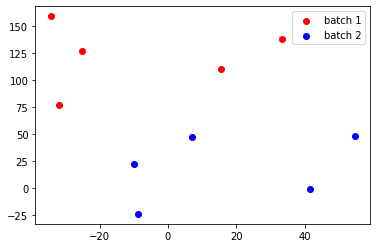

In [ ]:
from transformers import AutoModelWithLMHead, AutoModelForTokenClassification
import torch
import torch.nn as nn

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased")
# This identity function is used to by pass the randomly initialized classifier head
model.classifier = nn.Identity()

inputs1 = ["Hello, my dog is cute", "Your cat is very beautiful", "I love all animals", "animals are so fun to play with", "my fish are dying"]
inputs1 = tokenizer(inputs1, padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs1)
print(outputs['logits'].shape)
# Perform the average pool using all tokens other than the first token.
pooled1 = torch.mean(outputs['logits'][:,1:,], dim=1)

inputs2 = ["I love playing tennis", "Soccer is a sport where you kick a ball around", 
           "I think basketball is better than all other sports", "playing sports is good for your health", "where do you want to play soccer tonight?"]
inputs2 = tokenizer(inputs2,  padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs2)
print(outputs['logits'].shape)
pooled2 = torch.mean(outputs['logits'][:,1:,], dim=1)
visualize_two_batches(pooled1.detach().numpy(), pooled2.detach().numpy())


Here we compare pairs of sentences using the cosine similarity. Notice the first two sentences have much higher similarity since they are both about animals.

In [ ]:
from transformers import AutoModelWithLMHead,AutoModelForTokenClassification
import torch.nn as nn

model = AutoModelForTokenClassification.from_pretrained('distilbert-base-uncased')
model.classifier = nn.Identity()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
input1 = tokenizer("Hello, my dog is cute", padding=True, truncation=True, return_tensors="pt")
input2 = tokenizer("I love all animals", padding=True, truncation=True, return_tensors="pt")
input3 = tokenizer("Soccer is a sport where you kick a ball around", padding=True, truncation=True, return_tensors="pt")

output1 = model(**input1)
output2 = model(**input2)
output3 = model(**input3)
pooled1 = torch.mean(output1['logits'][:,1:,], dim=1)
pooled2 = torch.mean(output2['logits'][:,1:,], dim=1)
pooled3 = torch.mean(output3['logits'][:,1:,], dim=1)

print("the similarity between input1 and input2 is:")
cos_sim = torch.nn.functional.cosine_similarity(pooled1, pooled2)
print(cos_sim)
print("the similarity between input1 and input3 is:")
cos_sim = torch.nn.functional.cosine_similarity(pooled1, pooled3)
print(cos_sim)
print("the similarity between input2 and input3 is:")
cos_sim = torch.nn.functional.cosine_similarity(pooled2, pooled3)
print(cos_sim)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

the similarity between input1 and input2 is:
tensor([0.7746], grad_fn=<SumBackward1>)
the similarity between input1 and input3 is:
tensor([0.6561], grad_fn=<SumBackward1>)
the similarity between input2 and input3 is:
tensor([0.6469], grad_fn=<SumBackward1>)


Now we try to generate embeddings for entire sentences using the CLS token output by itself by removing the linear layer for a classification model and replacing it with the identity function. We visualize these embeddings. Notice it does not do as a good a job at separating the two batches of sentences as the previous average pooling method.

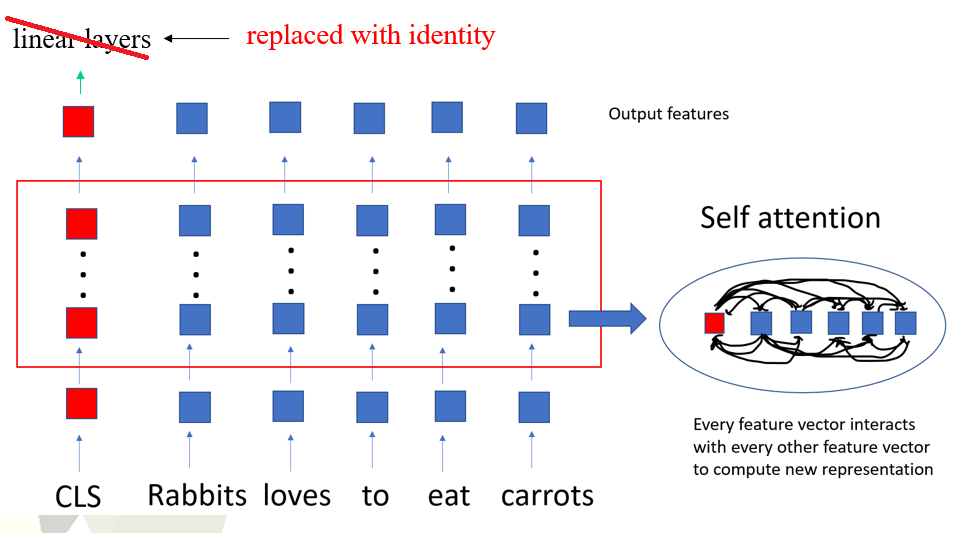

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

torch.Size([5, 768])
torch.Size([5, 768])


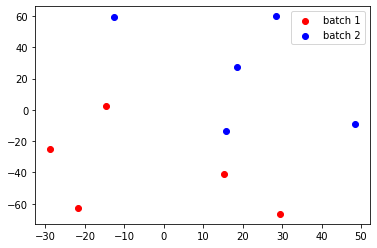

In [ ]:
from transformers import DistilBertConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch.nn as nn
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
#This line replaces the classification layer with the identity function so we can directly use the output of the CLS token.
model.classifier = nn.Identity()

inputs1 = ["Hello, my dog is cute", "Your cat is very beautiful", "I love all animals", "animals are so fun to play with", "my fish are dying"]
inputs1 = tokenizer(inputs1, padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs1)
print(outputs['logits'].shape)
outputs1 = outputs['logits']

inputs2 = ["I love playing tennis", "Soccer is a sport where you kick a ball around", 
           "I think basketball is better than all other sports", "playing sports is good for your health", "where do you want to play soccer tonight?"]
inputs2 = tokenizer(inputs2,  padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs2)
outputs2 = outputs['logits']
print(outputs['logits'].shape)
visualize_two_batches(outputs1.detach().numpy(), outputs2.detach().numpy())


Here we compare pairs of sentences using the cosine similarity for the classification model which uses the CLS token. Notice this method produces similarity scores that do not separate the animal versus sport sentences as well as the previous method.

In [ ]:

from transformers import DistilBertModel
import torch

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.classifier = nn.Identity()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
input1 = tokenizer("Hello, my dog is cute", padding=True, truncation=True, return_tensors="pt")
input2 = tokenizer("I love all animals", padding=True, truncation=True, return_tensors="pt")
input3 = tokenizer("Soccer is a sport where you kick a ball around", padding=True, truncation=True, return_tensors="pt")

output1 = model(**input1)
output2 = model(**input2)
output3 = model(**input3)

print("the similarity between input1 and input2 is:")
cos_sim = torch.nn.functional.cosine_similarity(output1['logits'], output2['logits'])
print(cos_sim)
print("the similarity between input1 and input3 is:")
cos_sim = torch.nn.functional.cosine_similarity(output1['logits'], output3['logits'])
print(cos_sim)
print("the similarity between input2 and input3 is:")
cos_sim = torch.nn.functional.cosine_similarity(output2['logits'], output3['logits'])
print(cos_sim)




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

the similarity between input1 and input2 is:
tensor([0.9560], grad_fn=<SumBackward1>)
the similarity between input1 and input3 is:
tensor([0.9138], grad_fn=<SumBackward1>)
the similarity between input2 and input3 is:
tensor([0.9293], grad_fn=<SumBackward1>)
